# Earthquakes 1990-2023 EDA and Predictions
https://www.kaggle.com/datasets/alessandrolobello/the-ultimate-earthquake-dataset-from-1990-2023

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.graphics import tsaplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import pickle

%matplotlib inline

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Dataset

In [ ]:
earthquake_df = pd.read_csv("drive/MyDrive/Eartquakes-1990-2023.csv")
earthquake_df.head()

,time,place,status,tsunami,significance,data_type,magnitudo,state,longitude,latitude,depth,date
0,631153353990,"12 km NNW of Meadow Lakes, Alaska",reviewed,0,96,earthquake,2.50,Alaska,-149.669200,61.730200,30.100,1990-01-01 00:22:33.990000+00:00
1,631153491210,"14 km S of Volcano, Hawaii",reviewed,0,31,earthquake,1.41,Hawaii,-155.212333,19.317667,6.585,1990-01-01 00:24:51.210000+00:00
2,631154083450,"7 km W of Cobb, California",reviewed,0,19,earthquake,1.11,California,-122.806167,38.821000,3.220,1990-01-01 00:34:43.450000+00:00
3,631155512130,"11 km E of Mammoth Lakes, California",reviewed,0,15,earthquake,0.98,California,-118.846333,37.664333,-0.584,1990-01-01 00:58:32.130000+00:00
4,631155824490,"16km N of Fillmore, CA",reviewed,0,134,earthquake,2.95,California,-118.934000,34.546000,16.122,1990-01-01 01:03:44.490000+00:00


# **Preprocessing:**

Filtering only earthquake data_type

In [ ]:
earthquake_df = earthquake_df.loc[earthquake_df['data_type'] == 'earthquake']

Dropping columns: place, status, tsunami, data_type

In [ ]:
earthquake_df = earthquake_df.drop(['place', 'status', 'tsunami', 'data_type'], axis=1)

Missing Values

In [ ]:
earthquake_df.isna().sum()

time            0
significance    0
magnitudo       0
state           0
longitude       0
latitude        0
depth           0
date            0
dtype: int64

Data Types

In [ ]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3361846 entries, 0 to 3445750
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   time          int64  
 1   significance  int64  
 2   magnitudo     float64
 3   state         object 
 4   longitude     float64
 5   latitude      float64
 6   depth         float64
 7   date          object 
dtypes: float64(4), int64(2), object(2)
memory usage: 230.8+ MB


Duplicates

In [ ]:
# Finding duplicate rows
duplicate_rows_count = earthquake_df[earthquake_df.duplicated(keep='first')].shape[0]

# Displaying the duplicate rows
print(f"Number of duplicate rows: {duplicate_rows_count}")

# Drop duplicates rows
earthquake_df.drop_duplicates(keep='first', inplace=True)

Number of duplicate rows: 16487


In [ ]:
earthquake_df.shape

(3345359, 8)

<ipython-input-43-066741e1b985>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

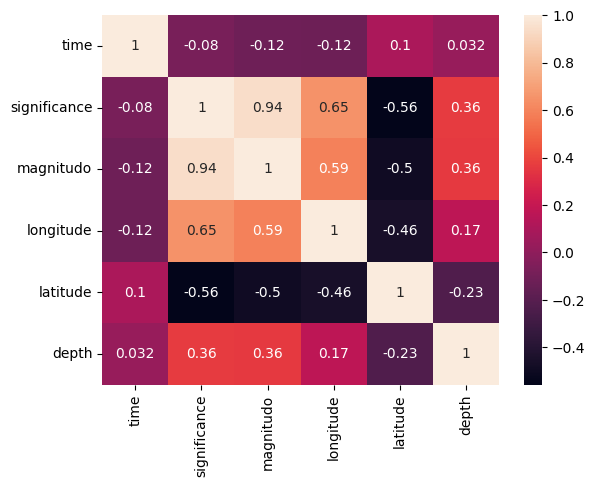

In [ ]:
sns.heatmap(earthquake_df.corr(), annot=True)

Magnitude and Significance are highly corelated, therefore we can drop significance

In [ ]:
earthquake_df = earthquake_df.drop(['significance'], axis=1)
earthquake_df.head()

,time,magnitudo,state,longitude,latitude,depth,date
0,631153353990,2.50,Alaska,-149.669200,61.730200,30.100,1990-01-01 00:22:33.990000+00:00
1,631153491210,1.41,Hawaii,-155.212333,19.317667,6.585,1990-01-01 00:24:51.210000+00:00
2,631154083450,1.11,California,-122.806167,38.821000,3.220,1990-01-01 00:34:43.450000+00:00
3,631155512130,0.98,California,-118.846333,37.664333,-0.584,1990-01-01 00:58:32.130000+00:00
4,631155824490,2.95,California,-118.934000,34.546000,16.122,1990-01-01 01:03:44.490000+00:00


In [ ]:
earthquake_df['state'].unique()

It seems the state column has countries, regions, and states of america.
We should rename this column to something more appropriate for the data it holds.

Also, renaming magnitudo to magnitude.

In [ ]:
earthquake_df = earthquake_df.rename(columns={"state": "region", "magnitudo": "magnitude"})
earthquake_df.head(5)

,time,magnitude,region,longitude,latitude,depth,date
0,631153353990,2.50,Alaska,-149.669200,61.730200,30.100,1990-01-01 00:22:33.990000+00:00
1,631153491210,1.41,Hawaii,-155.212333,19.317667,6.585,1990-01-01 00:24:51.210000+00:00
2,631154083450,1.11,California,-122.806167,38.821000,3.220,1990-01-01 00:34:43.450000+00:00
3,631155512130,0.98,California,-118.846333,37.664333,-0.584,1990-01-01 00:58:32.130000+00:00
4,631155824490,2.95,California,-118.934000,34.546000,16.122,1990-01-01 01:03:44.490000+00:00


Making date as a datetime type and removing time part.

In [ ]:
earthquake_df['date'] = pd.to_datetime(earthquake_df.date, format='%Y/%m/%d')
earthquake_df['date'] = earthquake_df['date'].dt.date
earthquake_df['date'] = pd.to_datetime(earthquake_df.date, format='%Y/%m/%d')
earthquake_df.head()

,time,magnitude,region,longitude,latitude,depth,date
0,631153353990,2.50,Alaska,-149.669200,61.730200,30.100,1990-01-01
1,631153491210,1.41,Hawaii,-155.212333,19.317667,6.585,1990-01-01
2,631154083450,1.11,California,-122.806167,38.821000,3.220,1990-01-01
3,631155512130,0.98,California,-118.846333,37.664333,-0.584,1990-01-01
4,631155824490,2.95,California,-118.934000,34.546000,16.122,1990-01-01


In [ ]:
earthquake_df.head(1)

,time,magnitude,region,longitude,latitude,depth,date
0,631153353990,2.5,Alaska,-149.6692,61.7302,30,1990-01-01


Transforming numerical features based on Domain knowledge

In [ ]:
def depth_levels(row):
   if row['depth'] <= 70:
      return 1
   elif row['depth'] <= 300:
      return 2
   else:
      r

earthquake_df['Risk'] = earthquake_df.apply(risk_levels, axis=1)

features = ['magnitude', 'depth', 'latitude', 'longitude']

for feature in features:
  earthquake_df[feature] = earthquake_df[feature].astype(int)
  earthquake_df[feature] = pd.Series(earthquake_df[feature]).apply(lambda x: custom_round(x, base=5))

Proprocessing region column to remove leading spaces.

In [ ]:
earthquake_df['region'] = earthquake_df['region'].str.strip()

Detecting Outliers

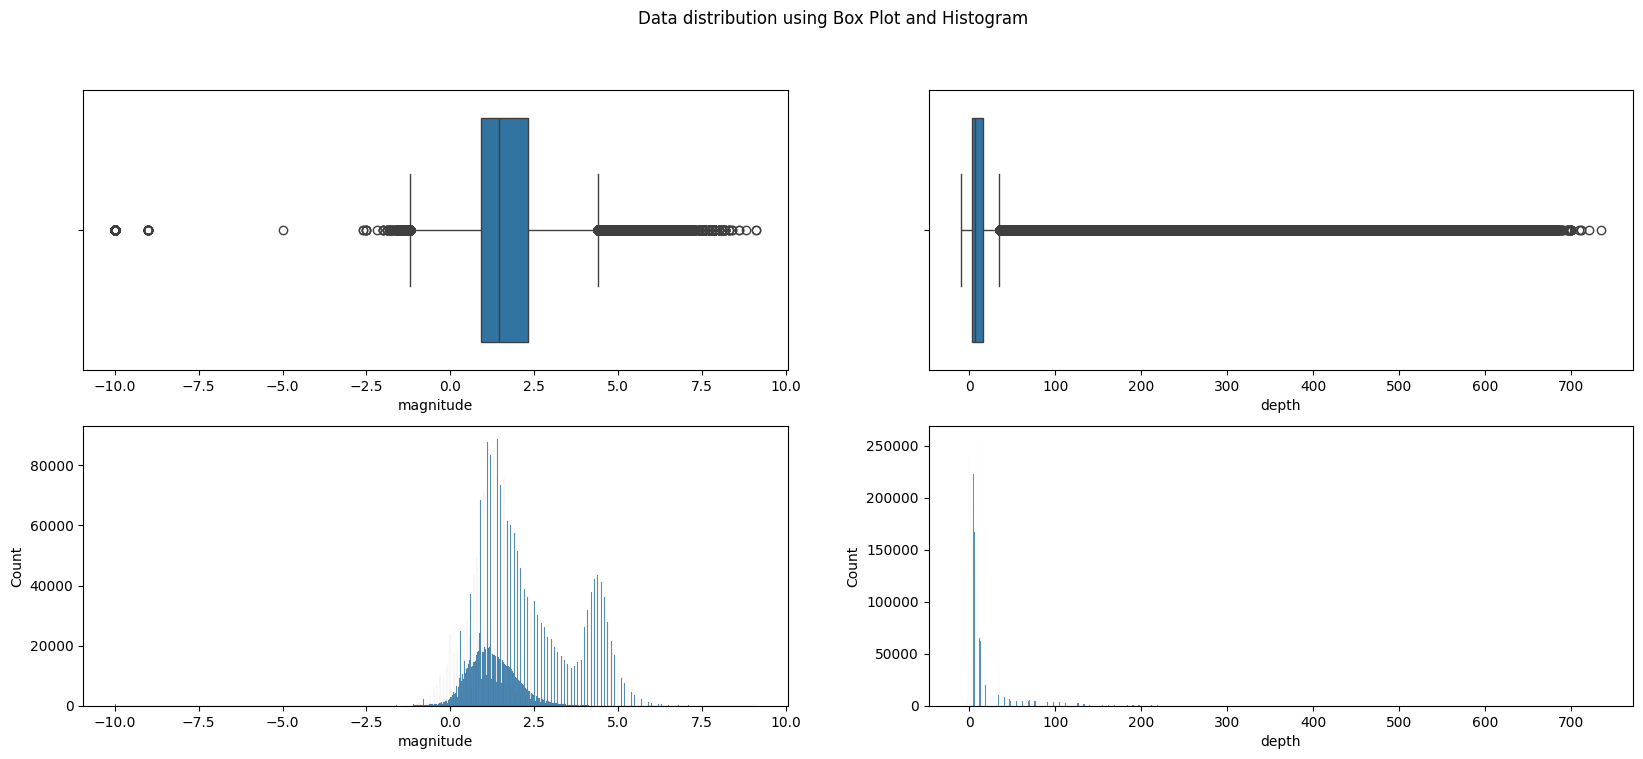

In [ ]:
def plotBoxAndHistPlot(featureList):
    noOfFeatures = len(featureList)
    fig, axes = plt.subplots(2, noOfFeatures, figsize=(20, 8))

    fig.suptitle('Data distribution using Box Plot and Histogram')

    for i in range(noOfFeatures):
        sns.boxplot(ax=axes[0, i], data=earthquake_df, x=featureList[i])
        sns.histplot(ax=axes[1, i], data=earthquake_df, x=featureList[i])

plotBoxAndHistPlot(['magnitude', 'depth'])

# Machine Learning Models

1.   K-means
2.   Time Searies Analysis
3.   Linear Regression (Peredict magnitude based on depth, latitude, longitude)



# K-means

Normalize / Scale

In [ ]:
# scaler = MinMaxScaler()
# earthquake_df_norm = scaler.fit_transform(earthquake_df.drop(['region', 'date'], axis=1))
earth_df = earthquake_df.drop(['date'], axis=1)
earth_df.set_index('region', inplace=True)
earth_df_norm = (earth_df - earth_df.mean())/earth_df.std()
earth_df_norm

,time,magnitude,longitude,latitude,depth
region,,,,,
Alaska,-2.074129,0.554068,-0.629225,1.189647,0.125719
Hawaii,-2.074129,-0.282461,-0.700455,-0.874133,-0.307502
California,-2.074127,-0.512699,-0.284031,0.074893,-0.361654
California,-2.074122,-0.612469,-0.233146,0.018610,-0.415807
California,-2.074121,0.899425,-0.234273,-0.133127,-0.126993
...,...,...,...,...,...
Japan,1.490626,2.165731,3.092297,-0.045311,1.082415
Alaska,1.490627,-0.059898,-0.681405,0.997923,0.017414
B.C.,1.490627,0.492672,-0.187535,-0.245669,-0.397756


Finding the best value for K

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

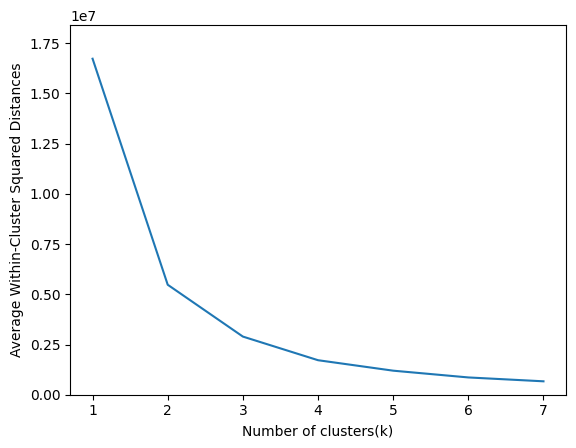

In [ ]:
inertia = []
cluster_limit = 7
for n_clusters in range(1, cluster_limit + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(earth_df_norm)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, cluster_limit + 1), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

In [ ]:
labels = KMeans(n_clusters=3, random_state=0).fit_predict(earth_df)
# Cluster membership
# memb = pd.Series(kmeans.labels_, index=earth_df_norm.index)
# for key, item in memb.groupby(memb):
#     print(key, ': ', ', '.join(item.index))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Depth vs Magnitude

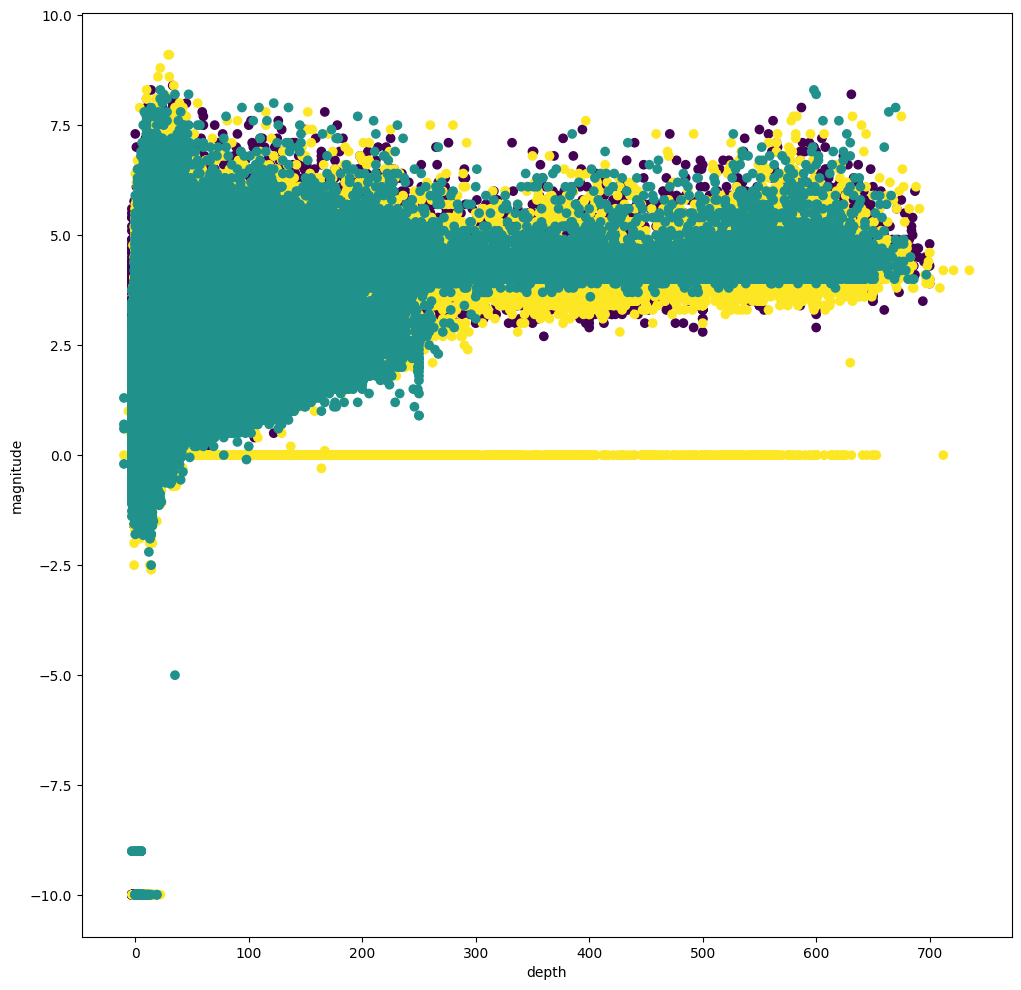

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

ax.set_xlabel("depth")
ax.set_ylabel("magnitude")

ax.scatter(earth_df.iloc[:, 4], earth_df.iloc[:, 1], c=labels)
plt.show()

Magnitude vs Location

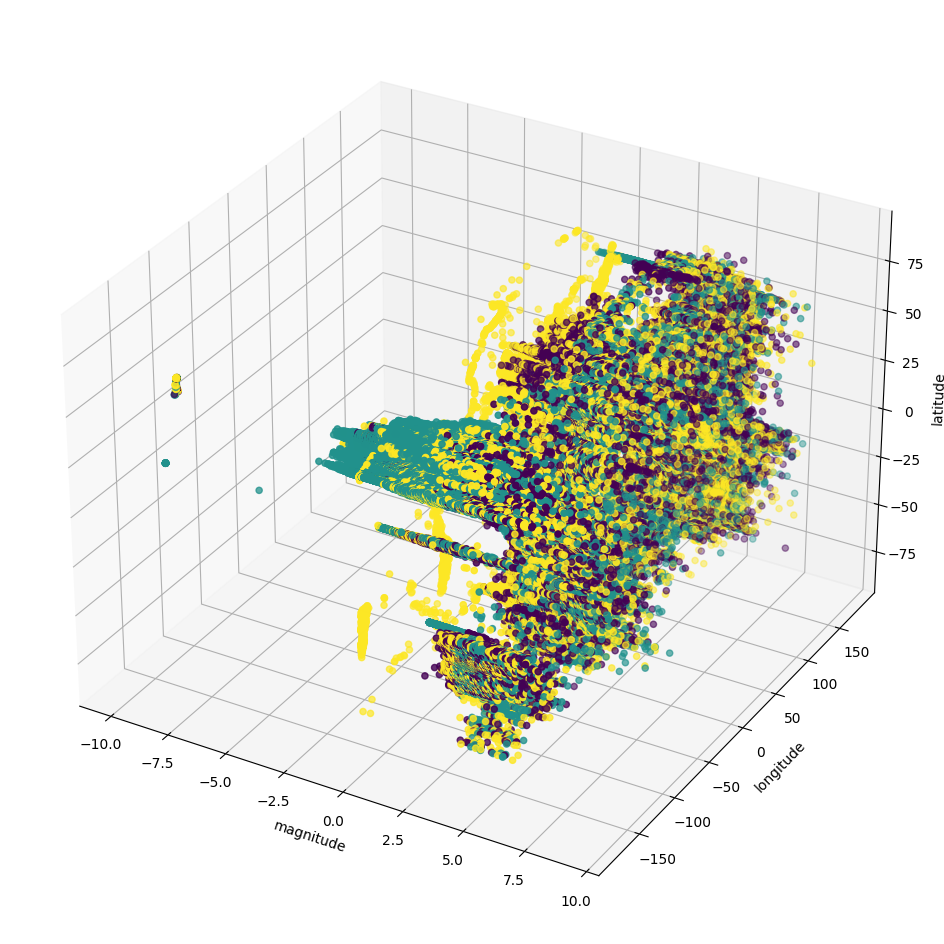

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel("magnitude")
ax.set_ylabel("longitude")
ax.set_zlabel("latitude", rotation=90)

ax.scatter(earth_df.iloc[:, 1], earth_df.iloc[:, 2], earth_df.iloc[:, 3], c=labels)
plt.show()

Time vs Location

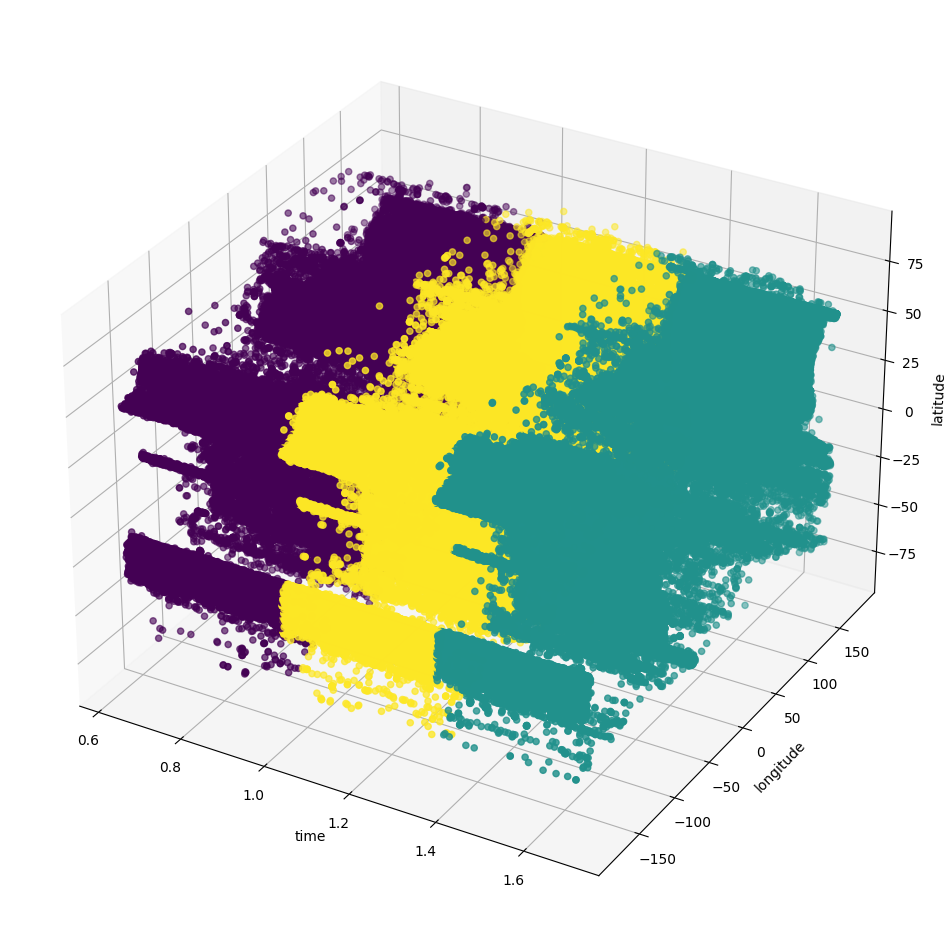

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel("time")
ax.set_ylabel("longitude")
ax.set_zlabel("latitude", rotation=90)

ax.scatter(earth_df.iloc[:, 0], earth_df.iloc[:, 2], earth_df.iloc[:, 3], c=labels)
plt.show()

**An IOPub error usually occurs when you try to print a large amount of data to the console.**

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=earth_df_norm.columns)
pd.set_option('display.precision', 3)
print(centroids)
pd.reset_option('display.precision')

    time  magnitude  longitude  latitude  depth
0 -0.515      1.336      2.146     0.164  0.062
1  0.707     -0.555     -0.238    -0.053 -0.299
2 -0.117      1.792      0.173    -2.468  0.569
3  0.580     -0.089     -0.675     1.104  0.268
4 -0.033      1.966      0.714    -2.324  8.613
5 -1.120     -0.243     -0.278     0.085 -0.278
6 -0.067      2.068      3.001    -2.054  0.627


# Time series analysis

In [ ]:
df=earthquake_df.copy()

ts = pd.Series(df.magnitude.values, index=df.date, name='magnitude')
ts.index = pd.DatetimeIndex(ts.index, freq=ts.index.inferred_freq)
ai_df = tsatools.add_trend(ts, trend='ct')
ai_df['Month']=ai_df.index.month

In [ ]:
valid=int(0.3*len(ts))
train=len(ts)-valid
train_df=ai_df[:train]
valid_df=ai_df[train:]

lm_poly_mon_trend=sm.ols(formula='magnitude ~ trend + C(Month)', data=train_df).fit()
pred_poly_mon_trend=lm_poly_mon_trend.predict(valid_df)
print(lm_poly_mon_trend.summary())
rmse=np.sqrt(mean_squared_error(valid_df['magnitude'], pred_poly_mon_trend))
print('RMSE for Model with month and trend')
print(rmse)

                            OLS Regression Results                            
Dep. Variable:              magnitude   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2399.
Date:                Wed, 21 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:12:24   Log-Likelihood:            -3.9673e+06
No. Observations:             2341752   AIC:                         7.935e+06
Df Residuals:                 2341739   BIC:                         7.935e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.1029      0.003    629.

Plot Graph

In [ ]:
#drop negative columns

# centered moving average with window size = 12
#ma_centered = ts.rolling(36, center=True).mean()

# trailing moving average with window size = 12
#ma_trailing = ts.rolling(36).mean()

# shift the average by one time unit
#ma_centered = pd.Series(ma_centered[:-1].values, index=ma_centered.index[1:])
#ma_trailing = pd.Series(ma_trailing[:-1].values, index=ma_trailing.index[1:])

# partition the data
#nValid = int(0.3*len(ts))
#nTrain = len(ts) - nValid

train_ts = ts[:train]
valid_ts = ts[train:]

train_ts=pd.Series(train_ts.values, index=train_ts.index.to_period('M'))
valid_ts=pd.Series(valid_ts.values, index=valid_ts.index.to_period('M'))

# moving average on training
#ma_trailing = train_ts.groupby(train_ts.index).mean()
ma_trailing = ts.rolling(365).mean()
last_ma = ma_trailing[-1]

#print(ma_trailing)
#print(last_ma)
#print(train_ts)

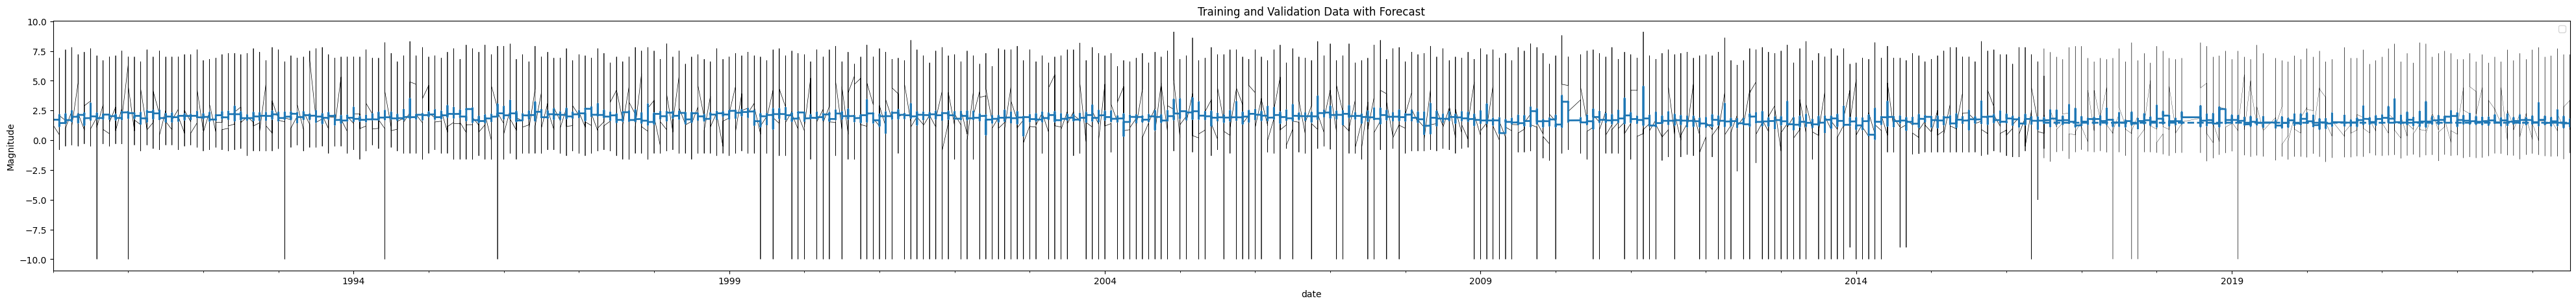

In [ ]:
# create forecast based on last moving average in the training period
ma_trailing_pred = pd.Series(last_ma, index=valid_ts.index)

fig, ax = plt.subplots(figsize=(50,5))

# Set x-axis limit
ax.set_xlim([-10, 10])
#ax.set_xlim([1990, 2023])
# Add legend, labels, and title
ax.legend(['Train', 'Validation', 'Moving Average', 'Forecast'])
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')
ax.set_title('Training and Validation Data with Forecast')

train_ts.plot(ax=ax, color='black', linewidth=0.5)
valid_ts.plot(ax=ax, color='black', linewidth=0.25)
ma_trailing.plot(ax=ax, linewidth=2, color='C0')
ma_trailing_pred.plot(ax=ax, style='--', linewidth=2, color='C0')

plt.show()

Build a model with seasonality, trend, and quadratic trend to get Prediction

In [ ]:
df = tsatools.add_trend(ts, trend='ct')
df['Month'] = df.index.month

# partition the data
train_df = df[:train]
valid_df = df[train:]

formula = 'magnitude ~ trend + C(Month)'
lm_trendseason = sm.ols(formula=formula, data=train_df).fit()

# create single-point forecast
prediction = lm_trendseason.predict(valid_df.iloc[0, :])

# apply MA to residuals
ma_trailing = lm_trendseason.resid.rolling(12).mean()

print('Prediction', prediction[0])
print('ma_trailing', ma_trailing[-1])

Prediction 1.586678499124
ma_trailing 0.06748677508948842


# **Linear Regression**

We are predicting magnitude based on longitude, latitude and depth.

In [ ]:
pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 40.9 MB/s eta 0:00:00


In [ ]:
import dmba
from dmba import regressionSummary
from sklearn.metrics import r2_score

Colab environment detected.


In [ ]:
earthquake_df_3 = earthquake_df[['magnitude', 'longitude', 'latitude', 'depth']]
earthquake_df_3.iloc[:,1:3] = earthquake_df_3.iloc[:,1:3].astype(int)
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

earthquake_df_3['longitude'] = pd.Series(earthquake_df_3['longitude']).apply(lambda x: custom_round(x, base=5))
earthquake_df_3['latitude'] = pd.Series(earthquake_df_3['latitude']).apply(lambda x: custom_round(x, base=5))

earthquake_df_3

<ipython-input-66-cd7b5b3666a0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-66-cd7b5b3666a0>:2: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

<ipython-input-66-cd7b5b3666a0>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-66-cd7b5b3666a0>:7: Setting

,magnitude,longitude,latitude,depth
0,2.50,-150,60,30
1,1.41,-155,20,6
2,1.11,-120,40,3
3,0.98,-120,35,0
4,2.95,-120,35,16
...,...,...,...,...
3445746,4.60,140,35,83
3445747,1.70,-155,55,24
3445748,2.42,-115,30,1
3445749,1.03,-120,40,1


In [ ]:
def earthquake_category(magnitude):
    if magnitude < 3:
        return 1
    elif 3 >= magnitude < 4:
        return 2
    elif 4 >= magnitude < 5:
        return 3
    elif 5 >= magnitude < 6:
        return 4
    elif 7 >= magnitude < 8:
        return 5
    else:
        return 6

earthquake_df_3['class'] = earthquake_df_3['magnitude'].apply(earthquake_category)

<ipython-input-67-13151625f3b0>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
earthquake_df_3

,magnitude,longitude,latitude,depth,class
0,2.50,-150,60,30,1
1,1.41,-155,20,6,1
2,1.11,-120,40,3,1
3,0.98,-120,35,0,1
4,2.95,-120,35,16,1
...,...,...,...,...,...
3445746,4.60,140,35,83,4
3445747,1.70,-155,55,24,1
3445748,2.42,-115,30,1,1
3445749,1.03,-120,40,1,1


In [ ]:
X = earthquake_df_3.drop(columns=['class'])
y = earthquake_df_3['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

regressionSummary(y_test, y_pred)

print(r2_score(y_test, y_pred)*100,'%')

Mean Absolute Error: 0.3542011242018558

Regression statistics

                      Mean Error (ME) : 0.0002
       Root Mean Squared Error (RMSE) : 0.4764
            Mean Absolute Error (MAE) : 0.3542
          Mean Percentage Error (MPE) : -5.7304
Mean Absolute Percentage Error (MAPE) : 28.5551
78.83161454150405 %


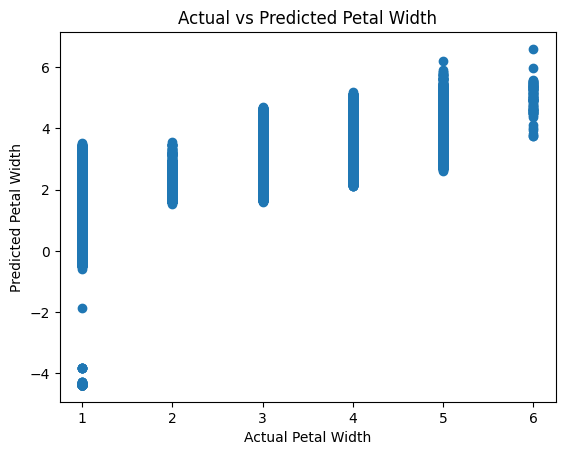

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Petal Width')
plt.ylabel('Predicted Petal Width')
plt.title('Actual vs Predicted Petal Width')
plt.show()

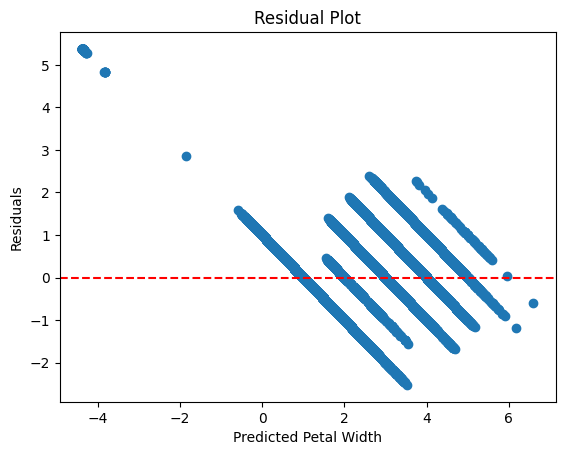

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Petal Width')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [ ]:
# Saving model to disk
pickle.dump(linear_model, open('linear_model.pkl','wb'))

#print(linear_model.predict([[-151.4756, 62.9447, 5]]))

# **Visualisation:**

In [ ]:
earthquake_df_vis = earthquake_df.copy()
earthquake_df_vis['year'] = earthquake_df_vis.date.dt.year
earthquake_df_vis['month'] = earthquake_df_vis.date.dt.month
earthquake_df_vis = earthquake_df_vis[earthquake_df_vis['magnitude'] > 0]
earthquake_df_vis.head(5)

,time,magnitude,region,longitude,latitude,depth,date,year,month
0,631153353990,2.50,Alaska,-149.669200,61.730200,30,1990-01-01,1990,1
1,631153491210,1.41,Hawaii,-155.212333,19.317667,6,1990-01-01,1990,1
2,631154083450,1.11,California,-122.806167,38.821000,3,1990-01-01,1990,1
3,631155512130,0.98,California,-118.846333,37.664333,0,1990-01-01,1990,1
4,631155824490,2.95,California,-118.934000,34.546000,16,1990-01-01,1990,1


Animation for series of earthquakes happened accross globe between 1990-2023:

In [ ]:
import plotly.express as px

gb_top = earthquake_df_vis.groupby(["region"])\
            .agg({"magnitude":"max"})\
            .reset_index()

b = earthquake_df_vis[["year", "region", "longitude", "latitude", "magnitude"]]
merge = pd.merge(gb_top, b, how = "left", on =["region", "magnitude"]).sort_values(by="year")

fig = px.scatter_geo(merge,
                    lat="latitude", lon="longitude",
                    size="magnitude",
                    animation_frame="year",
                    projection="natural earth",
                    title = "Series of earthquakes by year(1990-2023)" ,
                    template='plotly_dark'
)
fig.show()